In [1]:
import os
import sys
import logging

import pandas as pd

# import seaborn as sns
# sns.set_theme()
# sns.set_color_codes()
import matplotlib.pyplot as plt
import numpy as np

import plotly.express as px
import plotly.io as pio

pio.renderers.default = "svg"  # comment this line to use interactive plots
import plotly.graph_objects as go


# logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
sys.path.append("../components/paddock/")

%load_ext autoreload
%autoreload 2

from telemetry.influx import Influx
from telemetry.analyzer import Analyzer

from IPython.display import Image

pd.set_option("display.max_columns", None)

influx = Influx()
influx.laps_from_file("iracing.csv")
analyzer = Analyzer()

In [2]:
(
    game,
    session,
    track,
    car,
    # ) = "iRacing,1674828783,barcelona gp,Ferrari 488 GT3 Evo 2020".split(",")      # circuit
    # ) = "iRacing,1674679321,phoenix rallycross,Volkswagen Beetle GRC ".split(",")  # rallycross
    # ) = "iRacing,1670307078,fiveflags,Chevrolet Monte Carlo SS".split(",")         # oval
    # ) = "iRacing,1673296770,nurburgring nordschleifetourist,Porsche 911 GT3 Cup (991)".split(",")         # long track
) = "iRacing,1676736012,limerock 2019 gp,Ferrari 488 GT3 Evo 2020".split(
    ","
)  # short track
all_laps = influx.telemetry_for(game=game, track=track, car=car)

In [3]:
# Resample to 1 meter intervals
df = all_laps[0].copy()
# remove all Gear == 0 rows
df = df[df["Gear"] != 0]
# display(df)
df = analyzer.resample(df, freq=1, columns=["Brake", "SpeedMs", "Throttle", "Gear"])
# # normalise SpeedMs and Gear
df["SpeedMsNormalized"] = df["SpeedMs"] / df["SpeedMs"].max()
df["GearNormalized"] = df["Gear"] / df["Gear"].max()

df

,DistanceRoundTrack,Brake,SpeedMs,Throttle,Gear,id,SpeedMsNormalized,GearNormalized
0,0.766194,0.0,66.250290,0.999106,5.0,1676736012-11,0.972012,1.0
1,1.766703,0.0,66.271325,0.999106,5.0,1676736012-11,0.972321,1.0
2,2.767212,0.0,66.288838,0.999106,5.0,1676736012-11,0.972578,1.0
3,3.767721,0.0,66.306692,0.998261,5.0,1676736012-11,0.972840,1.0
4,4.768231,0.0,66.326162,0.998650,5.0,1676736012-11,0.973126,1.0
...,...,...,...,...,...,...,...,...
2332,2333.953773,0.0,66.539721,0.996131,5.0,1676736012-11,0.976259,1.0
2333,2334.954282,0.0,66.561164,0.996131,5.0,1676736012-11,0.976574,1.0
2334,2335.954791,0.0,66.581534,0.996131,5.0,1676736012-11,0.976872,1.0
2335,2336.955301,0.0,66.601545,0.996131,5.0,1676736012-11,0.977166,1.0


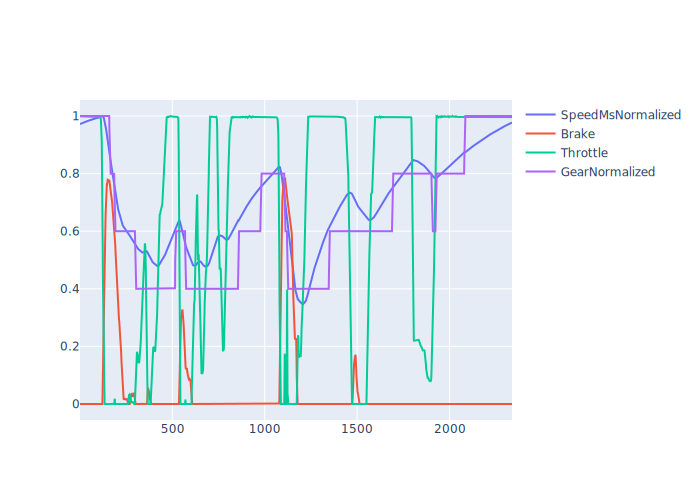

In [4]:
def lap_fig(df):
    fig = go.Figure()

    fig.add_scatter(
        x=df["DistanceRoundTrack"],
        y=df["SpeedMsNormalized"],
        marker=dict(size=2),
        name="SpeedMsNormalized",
    )

    fig.add_scatter(
        x=df["DistanceRoundTrack"],
        y=df["Brake"],
        marker=dict(size=1),
        name="Brake",
    )

    fig.add_scatter(
        x=df["DistanceRoundTrack"],
        y=df["Throttle"],
        marker=dict(size=1),
        name="Throttle",
    )

    fig.add_scatter(
        x=df["DistanceRoundTrack"],
        y=df["GearNormalized"],
        marker=dict(size=1),
        name="GearNormalized",
    )
    return fig


lap_fig(df).show()

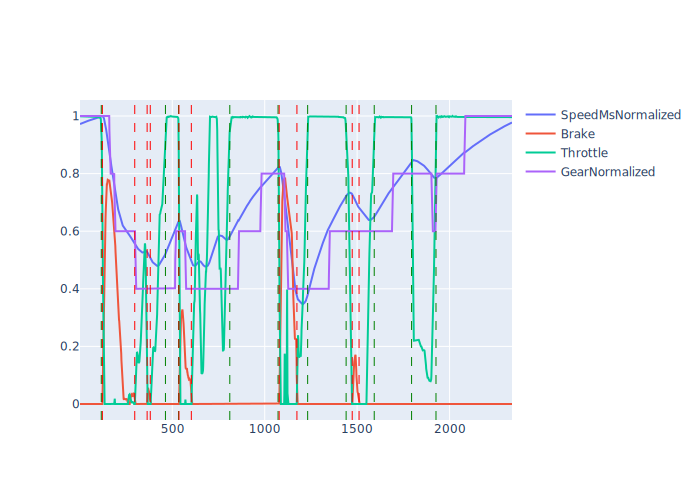

In [5]:
# break the track into segements, where throttle input is below 1
#  if you need to brake in a turn, you will release the throttle
#  if you dont need to brake, you might still release the throttle
#  if it's a full throttle turn, you will not release the throttle
#       - we might identify these by looking at the steering angle


def get_change_indices(df, column, threshold=0.9, below=True):
    X = df[column].values
    if below:
        mask = X <= threshold
    else:
        mask = X >= threshold
    change_indices = np.where(np.diff(mask))[0]
    # if len(change_indices) is odd, then the last value is a change
    if len(change_indices) % 2 == 1:
        print("adding last index")
        change_indices = np.append(change_indices, len(X))
    return change_indices


def remove_close_indices(indices, threshold=50):
    if len(indices) == 0:
        return indices
    # merge throttle changes that are close together
    new_indices = [
        indices[0],
        indices[1],
    ]
    for i in range(2, len(indices), 2):
        start_i = indices[i]
        end_i = indices[i + 1]
        previous_end = indices[i - 1]
        if start_i - previous_end <= threshold:
            new_indices[-1] = end_i
        else:
            new_indices.append(start_i)
            new_indices.append(end_i)
    return new_indices


throttle_changes = get_change_indices(df, "Throttle", threshold=0.95, below=True)
brake_changes = get_change_indices(df, "Brake", threshold=0.005, below=False)
# display(throttle_changes)
# display(brake_changes)

throttle_changes = remove_close_indices(throttle_changes)
brake_changes = remove_close_indices(brake_changes)
# display(throttle_changes)
# display(brake_changes)


fig = lap_fig(df)

# add a vertical line for each index
for idx in throttle_changes:
    fig.add_vline(
        x=df["DistanceRoundTrack"][idx],
        line_width=1,
        line_dash="dash",
        line_color="green",
    )
for idx in brake_changes:
    fig.add_vline(
        x=df["DistanceRoundTrack"][idx],
        line_width=1,
        line_dash="dash",
        line_color="red",
    )

fig.show()

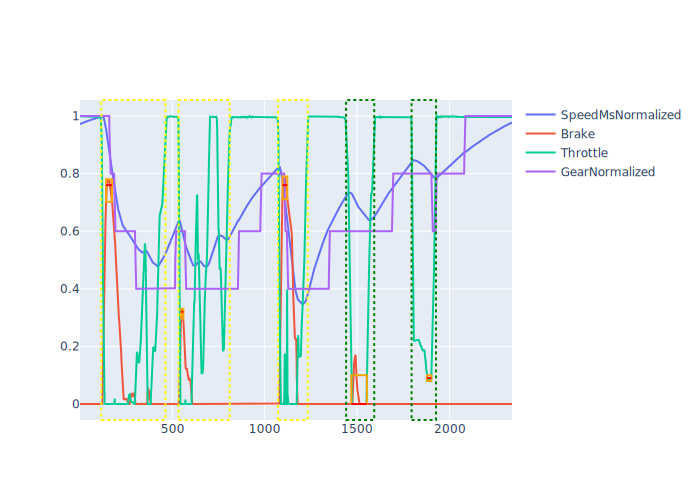

,type,seg_start,seg_end,color,start,end,high,low,avg_start,avg_end,average,gear,speed
0,brake,115,462,yellow,120,381,0.78,0.702,141,173,0.76,2.0,32.677555
1,brake,533,810,yellow,534,603,0.33,0.297,547,559,0.32,2.0,32.524377
2,brake,1071,1231,yellow,1076,1174,0.79,0.711,1095,1121,0.76,2.0,23.610069
3,throttle,1439,1591,green,1439,1591,0.10,0.000,1467,1551,0.00,3.0,43.514569
4,throttle,1793,1925,green,1793,1925,0.10,0.080,1876,1900,0.09,3.0,53.460373


In [6]:
def get_average(df, start_i, end_i, column="Brake", max=True):
    search_df = df[start_i:end_i]

    if max:
        high = abs(round(search_df[column].max(), 2))
        low = high * 0.9
        start = search_df[search_df[column] > low].index.min()
        end = search_df[search_df[column] > low].index.max()
        average = search_df[search_df[column] > low][column].mean()
    else:
        low = abs(round(search_df[column].min(), 2))
        high = low * 1.1
        if low <= 0.1:
            high = 0.1
        start = search_df[search_df[column] < high].index.min()
        end = search_df[search_df[column] < high].index.max()
        average = search_df[search_df[column] < high][column].mean()

    if np.isnan(average):
        average = (high + low) / 2

    return {
        "high": high,
        "low": low,
        "avg_start": start,
        "avg_end": end,
        "average": round(average, 2),
    }


fig = lap_fig(df)
segments = []
for i in range(0, len(throttle_changes), 2):
    start_i = throttle_changes[i]
    end_i = throttle_changes[i + 1]
    # find the closest number in the brake_idx array

    if len(brake_changes):
        # how far is the brake_idx from the start_idx
        brake_i = brake_changes[np.abs(brake_changes - start_i).argmin()]
    else:
        # no brake changes
        brake_i = 999999

    distance = np.abs(brake_i - start_i)
    segment = {
        "type": "brake",
        "seg_start": start_i,
        "seg_end": end_i,
        "color": "yellow",
    }
    if distance > 20:
        # we are not braking in this segment
        segment["type"] = "throttle"
        segment["color"] = "green"
        segment["start"] = start_i
        segment["end"] = end_i

        avg_data = get_average(df, start_i, end_i, column="Throttle", max=False)
        segment |= avg_data
    else:
        # search back 20 meters to find the start of the brake
        search_start = brake_i - 20
        if search_start < 0:
            search_start = 0
        search_df = df[search_start:brake_i]
        min = search_df["Brake"].min()
        brake_start_i = search_df[search_df["Brake"] == min].index.max()
        segment["start"] = brake_start_i

        search_df = df[brake_start_i:end_i]
        brake_end_i = search_df[search_df["Brake"] > min].index.max()
        segment["end"] = brake_end_i

        # find the max brake value
        avg_data = get_average(df, brake_i, end_i)
        segment |= avg_data

    fig.add_shape(
        type="rect",
        xref="x",
        yref="y",
        x0=df["DistanceRoundTrack"][avg_data["avg_start"]],
        y0=avg_data["low"],
        x1=df["DistanceRoundTrack"][avg_data["avg_end"]],
        y1=avg_data["high"],
        line=dict(color="orange", width=2),
    )

    fig.add_shape(
        type="line",
        xref="x",
        yref="y",
        x0=df["DistanceRoundTrack"][avg_data["avg_start"]],
        y0=avg_data["average"],
        x1=df["DistanceRoundTrack"][avg_data["avg_end"]],
        y1=avg_data["average"],
        line=dict(color="red", width=2),
    )

    fig.add_shape(
        type="rect",
        xref="x",
        yref="paper",
        x0=df["DistanceRoundTrack"][segment["seg_start"]],
        y0=0,
        x1=df["DistanceRoundTrack"][segment["seg_end"]],
        y1=1,
        line=dict(color=segment["color"], width=2, dash="dot"),
    )
    # get lowest gear in this segment
    segment["gear"] = df["Gear"][segment["seg_start"] : segment["seg_end"]].min()
    segment["speed"] = df["SpeedMs"][segment["seg_start"] : segment["seg_end"]].min()
    segments.append(segment)
fig.show()
pd.DataFrame(segments)